In [10]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit.quantum_info import random_unitary
from qreservoirpy import QReservoir, Layers, utilities

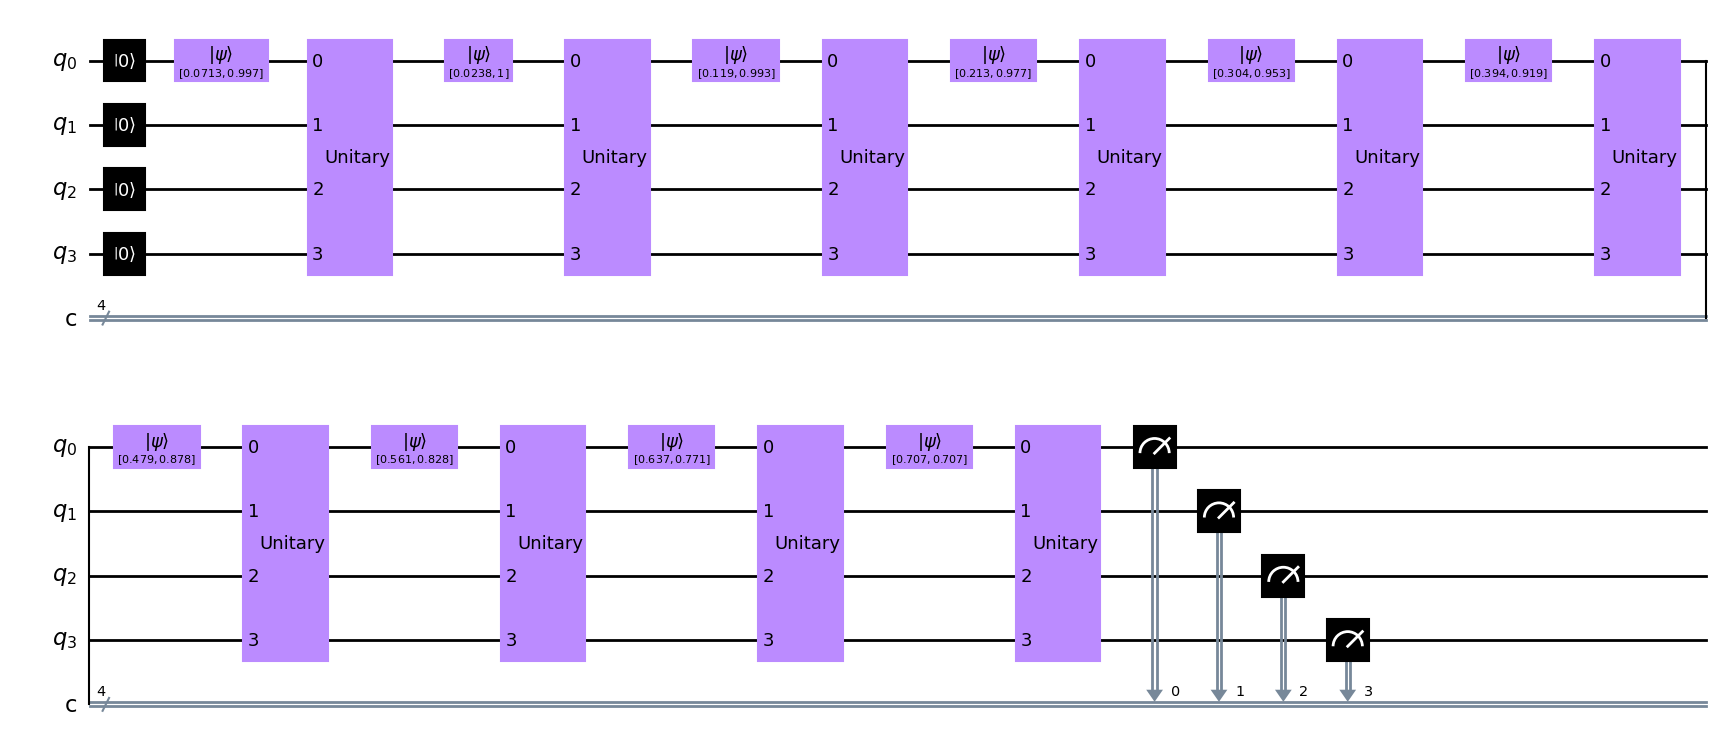

In [11]:
def build_method(circ, timestep, operator):
    circ.initialize(np.array([np.sqrt(timestep),
        np.sqrt(1-timestep)], dtype=complex
    ), 0)
    circ.unitary(operator, circ.qubits)
    return circ

res = QReservoir(qubits=4, layers=[
    Layers.Reset(),
    Layers.Timeseries(build_method=build_method, incrementally=True, M=5),
    Layers.Measurement(range(4))
], operator=random_unitary(2**4), analyze_function=lambda res: res[-4:])


target = (1 + np.sin(np.linspace(0, 6*np.pi, 100)))/2
states = res.run(target, shots=10000)

res.circuit.draw('mpl')



(<Figure size 2000x2000 with 4 Axes>,
 array([<Axes: title={'center': 'Feature 1'}>,
        <Axes: title={'center': 'Feature 2'}>,
        <Axes: title={'center': 'Feature 3'}>,
        <Axes: title={'center': 'Feature 4'}>], dtype=object))

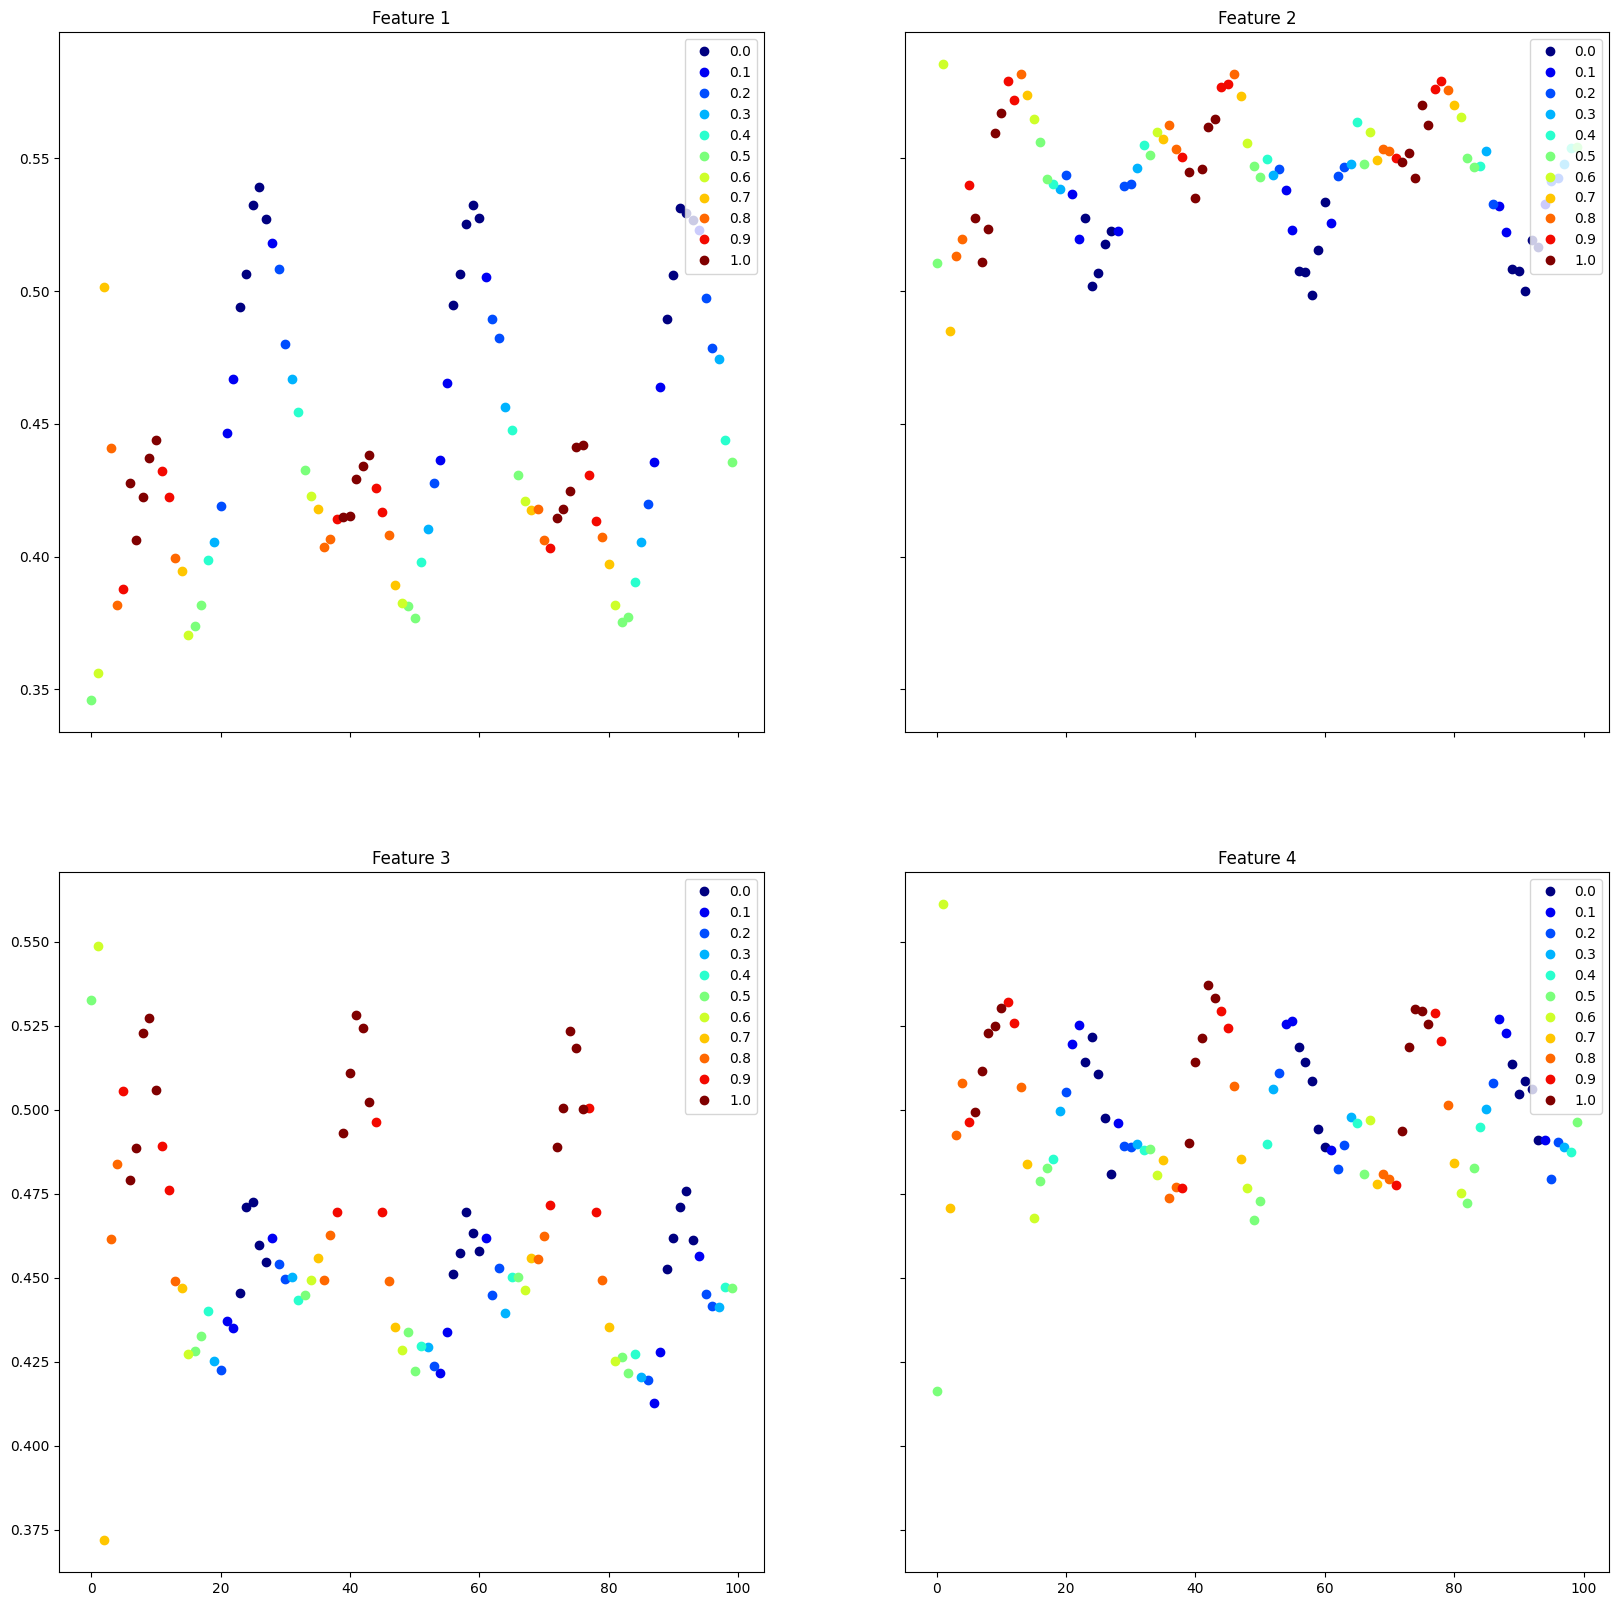

In [12]:
utilities.result_plotter(states, np.round(target, 1))